# Creating our own dataset from Google Images

*Insipired on the work by: Francisco Ingham and Jeremy Howard and [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*


The idea is to improve the method from previous week, since we had too much noise in our images.
Goal : Distinguish paints from people from the same art movement, impressionism.
* Renoir
* Monet
* Manet

In [1]:
from fastai.vision import *

## Get the URLs, images into the server

1. Go to Google Images and search for the artists
2. After scrolling through the batch that we want to download, input the following command in the console

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server
I upload the files into data/artists (path)

## Download Images
```download_images(path/file, dest)```

Now you will need to download you images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename and the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

### Monet

In [31]:
folder = 'monet'
file = 'urls_monet.txt'

In [39]:
path = Path('data/artists')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(path/file, dest, max_pics=200)

### Manet

In [35]:
folder = 'manet'
file = 'urls_manet.txt'

In [ ]:
path = Path('data/artists')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(path/file, dest, max_pics=200)

### Renoir

In [38]:
folder = 'renoir'
file = 'urls_renoir.txt'

In [ ]:
path = Path('data/artists')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(path/file, dest, max_pics=200)

In [33]:
path.ls()

[PosixPath('data/artists/monet'),
 PosixPath('data/artists/urls_monet.txt'),
 PosixPath('data/artists/urls_manet.txt'),
 PosixPath('data/artists/renoir'),
 PosixPath('data/artists/manet'),
 PosixPath('data/artists/urls_renoir.txt')]

In [19]:
classes = ['monet','manet','renoir']

### Clean images
Then we can remove any images that can't be opened:
**Important, there will always be corrupted images**

In [42]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

monet


manet


renoir


## View Data
ImageDataBunch can separate the training and validation set, with the option: valid_pct

In [43]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [44]:
data.classes

['manet', 'monet', 'renoir']

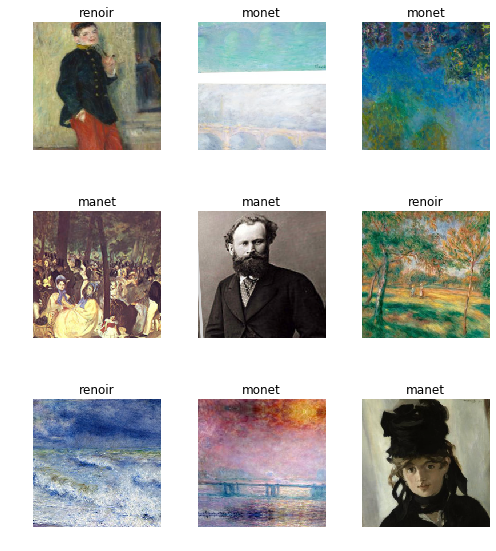

In [45]:
data.show_batch(rows=3, figsize=(7,8))

In [46]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['manet', 'monet', 'renoir'], 3, 480, 120)

## Training
Time to train the model. 

In [47]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [48]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.363010,0.874040,0.408333
2,1.031776,0.728608,0.325000
3,0.879943,0.740481,0.300000
4,0.765333,0.733090,0.300000


In [49]:
learn.save('stage-1')

In [50]:
learn.unfreeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


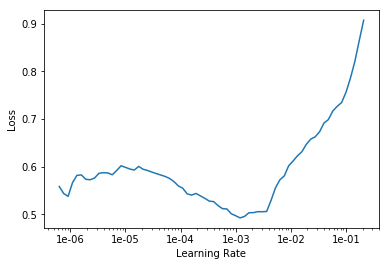

In [52]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,3e-3))

epoch,train_loss,valid_loss,error_rate
1,0.587058,0.767858,0.283333
2,0.520621,0.670639,0.241667


We have improved the accuracy, but it is still very low. 
The idea is to see which images it is classifying wrong, and them clean the training and validation sets

In [54]:
learn.save('stage-2')

## Interpretation

In [55]:
learn.load('stage-2');

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

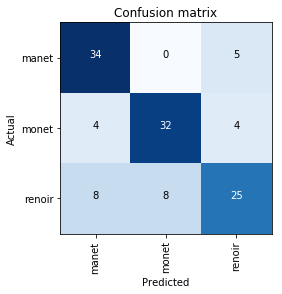

In [57]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [58]:
from fastai.widgets import *

In [59]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [60]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Re-train
Once we have "removed" the images that shouldn't be part of our set, and let's train again. 
The cleaning set is part of cleaned.csv, so we need to include that in our image bunch

In [63]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [64]:
data.classes

['manet', 'monet', 'renoir']

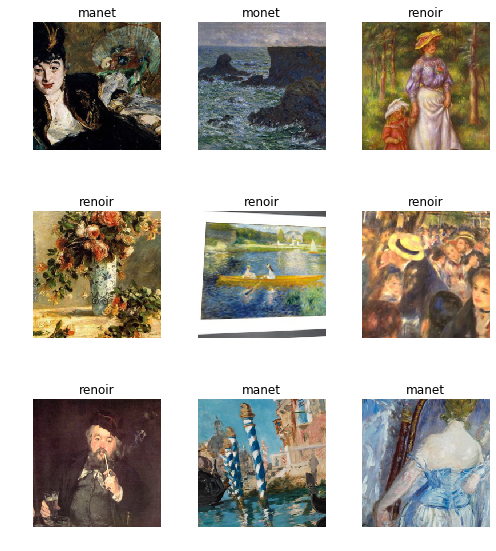

In [65]:
data.show_batch(rows=3, figsize=(7,8))

In [66]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['manet', 'monet', 'renoir'], 3, 378, 94)

In [67]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [68]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.310672,0.795726,0.372340
2,1.060318,0.600702,0.191489
3,0.900829,0.600083,0.191489
4,0.795167,0.615504,0.212766


Still not a good enough accuracy.
Let's vary the learning rate and see if we can do something

In [69]:
learn.save('clean-stage-1')

In [76]:
learn.unfreeze()

In [77]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


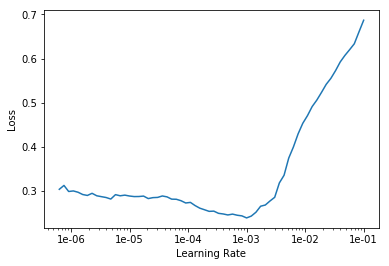

In [78]:
learn.recorder.plot()

In [79]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.292919,0.954396,0.297872
2,0.289945,1.024951,0.308511


In [80]:
learn.save('clean-stage-2')